# Instagram Engagement Enhancer

In this project, we embark on a journey to enhance Instagram engagement through a meticulous analysis of image content. Leveraging the power of Google Vision API, we first extract labels from Instagram images, serving as a foundation for our subsequent analysis. The core of our exploration lies in performing Latent Dirichlet Allocation (LDA) for topic modeling, where we meticulously determine the optimal number of topics to ensure a robust analysis. This process involves a detailed examination to identify the most coherent topic distribution, culminating in the selection of an appropriate number of topics for our dataset.

After identifying the topics, we conducted a detailed analysis of the top 25 words for each topic, uncovering key themes and concepts prevalent in high-engagement Instagram posts. To name these topics, we employed a large language model from OpenAI, which generated names based on the top 25 words, thereby allowing us to categorize the content more effectively and facilitate a structured analysis. The subsequent phase of our project was dedicated to comparing the engagement levels of Instagram posts by specifically analyzing the differences in topic weights between posts with high and low engagement. This involved sorting the data by the number of comments and examining the highest and lowest quartiles, through which we gained significant insights into the content preferences of Instagram users.

Our findings are meticulously documented, showcasing the main differences in average topic weights across different engagement levels. This analysis not only highlights the topics that resonate most with the audience but also sheds light on the content strategies that could potentially enhance user engagement on Instagram. The culmination of our project is presented in a comprehensive table, summarizing the key results and offering a clear comparison of topic prevalence in high versus low engagement quartiles. Through this analytical journey, we aim to provide actionable insights that can aid influencers and content creators in optimizing their Instagram engagement strategies.


## Import required libraries

In [12]:
from google_vision import label_images
from topic_modeling import find_optimal_topics, perform_lda
import os
import pandas as pd
import openai
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Extract, transform, and load labels from images

In [ ]:
# Define the directory where the instagram posts are stored
data_dir = './data/posts/'

# Initialize a list to store image paths and their post details together
posts_data = []

# Loop through the contents and check if each item is a file or directory
for item in os.listdir(data_dir):
    item_path = os.path.join(data_dir, item)
    if os.path.isdir(item_path):
        # Extract post details from the directory name
        username, follower_count, post_id, post_likes, post_comments = item.split('_')[-5:]
        # Iterate contents of the directory
        for file in os.listdir(item_path):
            file_path = os.path.join(item_path, file)
            if os.path.isfile(file_path) and file_path.endswith('.jpg'):
                # Add the file path and post details to the list as a dictionary
                posts_data.append({
                    'Image_Path': file_path,
                    'Username': username,
                    'Follower_Count': follower_count,
                    'Post_ID': post_id,
                    'Post_Likes': post_likes,
                    'Post_Comments': post_comments
                })
    else:
        continue

# Convert the list to a pandas DataFrame
posts_df = pd.DataFrame(posts_data)

# Save the DataFrame to a CSV file
posts_df.to_csv('./data/posts_data.csv', index=False)

# Get the labels from the images
labels_dict = label_images(posts_df['Image_Path'].tolist())

# Convert the dictionary to a pandas DataFrame
labels_df = pd.DataFrame(list(labels_dict.items()), columns=['Image_Path', 'Labels'])

# Save the DataFrame to a CSV file
labels_df.to_csv('./data/labels.csv', index=False)

# Merge the DataFrames to include image paths, labels, and post details
combined_df = pd.merge(posts_df, labels_df, on='Image_Path')

# Save the DataFrames to CSV files
combined_df.to_csv('./data/combined_data.csv', index=False)

In [3]:
# Re-load the combined data from the CSV file
combined_df = pd.read_csv('./data/combined_data.csv')
combined_df['Labels'] = combined_df['Labels'].apply(eval)

## 2. Perform topic modeling

In [4]:
labels_list = combined_df['Labels'].tolist()

# Get the optimal number of topics and the coherence score
model_list, coherence_values, optimal_num_topics = find_optimal_topics(labels_list)
print("Optimal number of topics:", optimal_num_topics)

Optimal number of topics: 11


"Musical Performance in Sportswear: Exploring the Human Leg and Flash Photography"
"Cozy Home Decor: Wood, Furniture, and Natural Elements"
"Graphic Design for Brand Promotion on Social Media"
"Delicious Dishes and Drinks: Exploring the World of Natural Cuisine"
"Sports Uniforms and Gear in Action: A Snapshot of a Baseball Game"
"Exploring the City in a Luxury Car: Automotive Design and Exterior Features"
"Portrait Photography and Fashion: Exploring the Human Body and Expressions"
"Joyful Fashion Showcase: Capturing the Elegance of a Pink Day Dress on the Red Carpet"
"Joyful Fashion and Eyewear at a Fun Event"
"Nature's Oasis: Exploring Azure Skies and Lush Landscapes with Happy People and Playful Pups"
"Facial Features and Expressions in Art and Fashion"


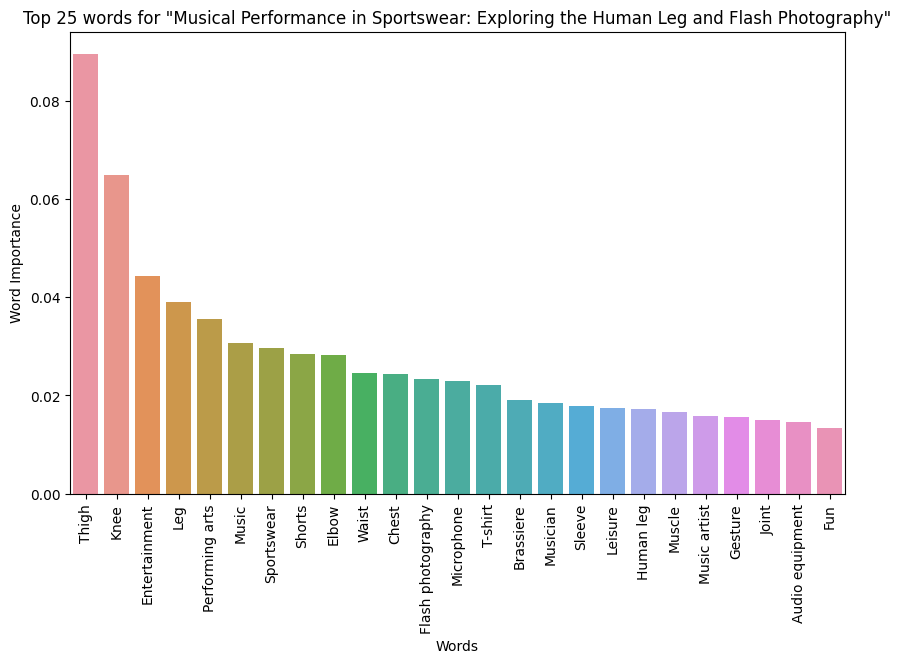

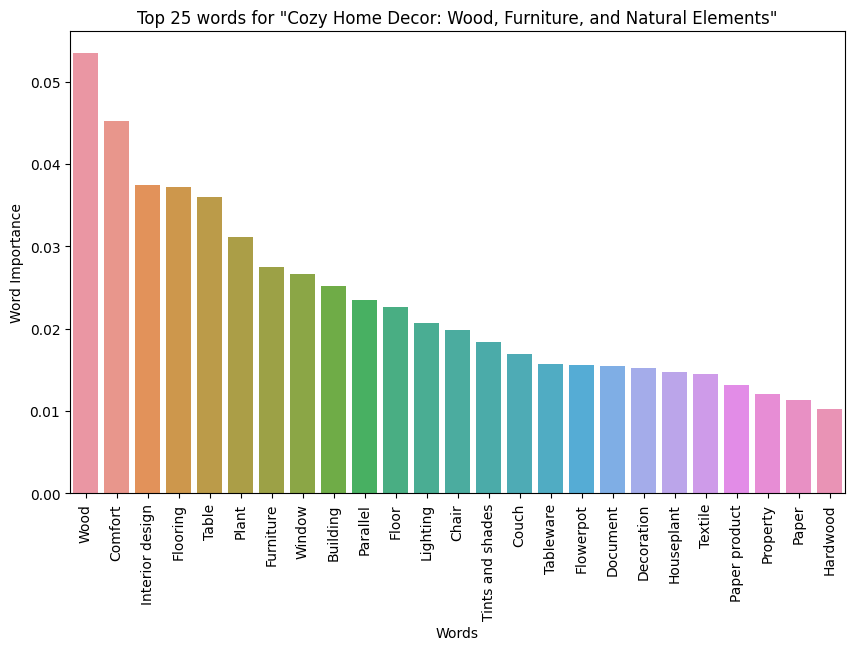

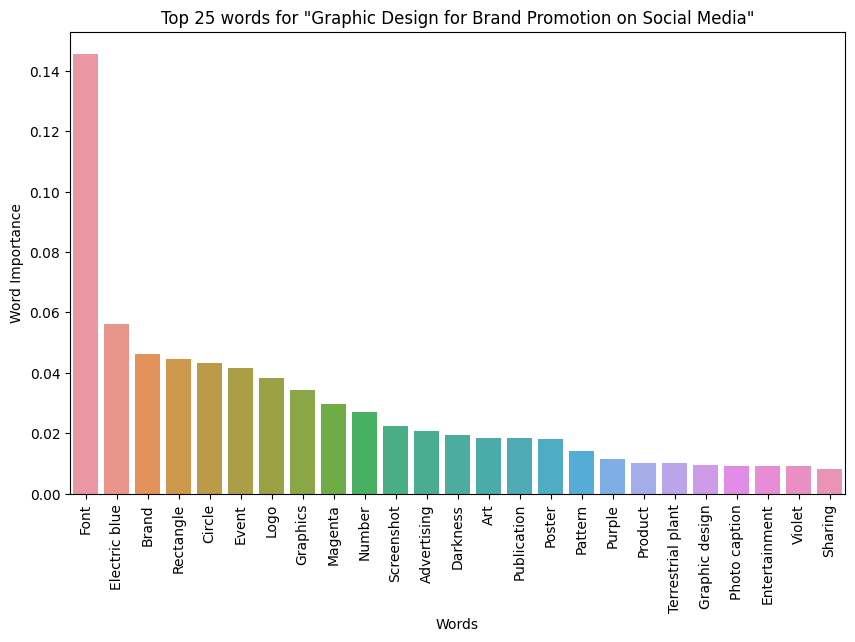

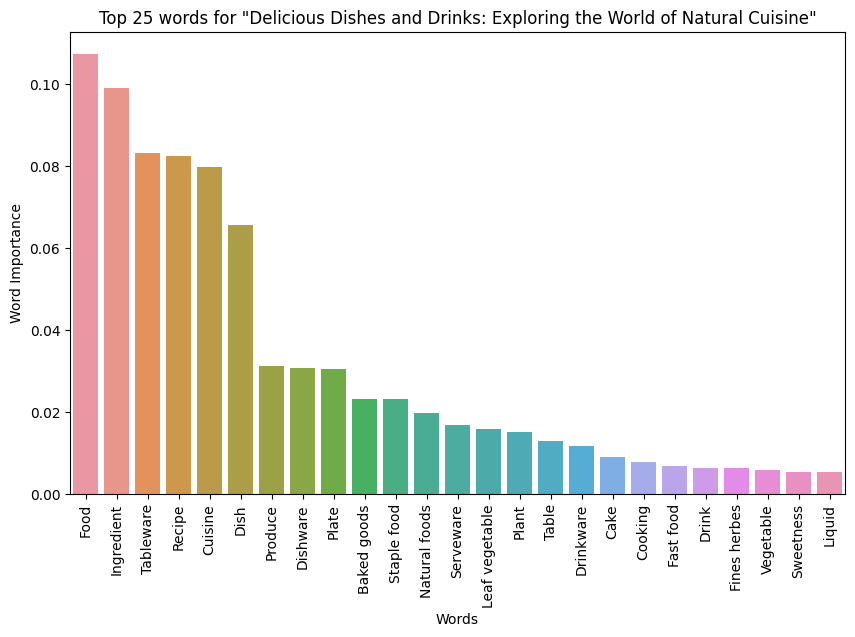

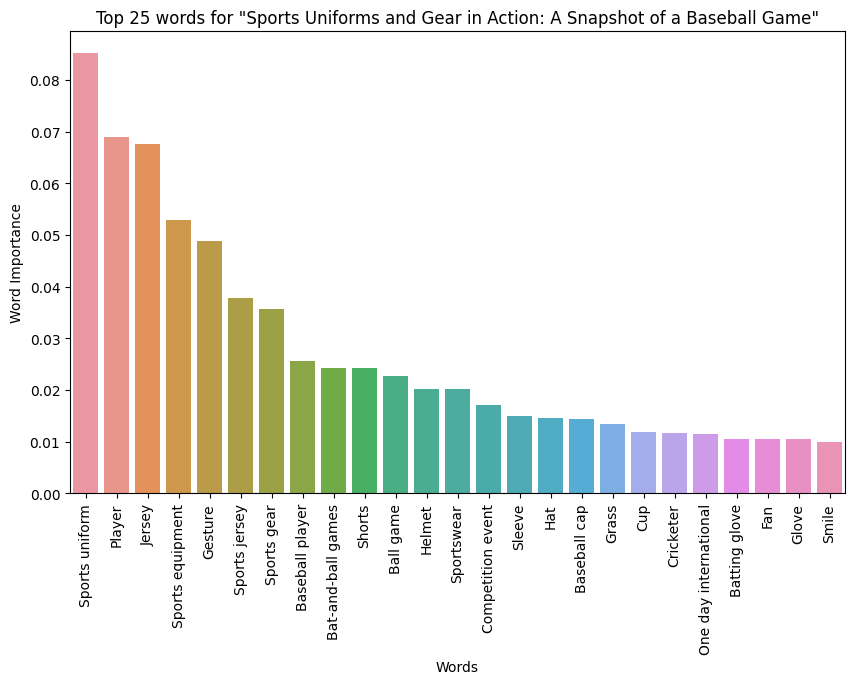

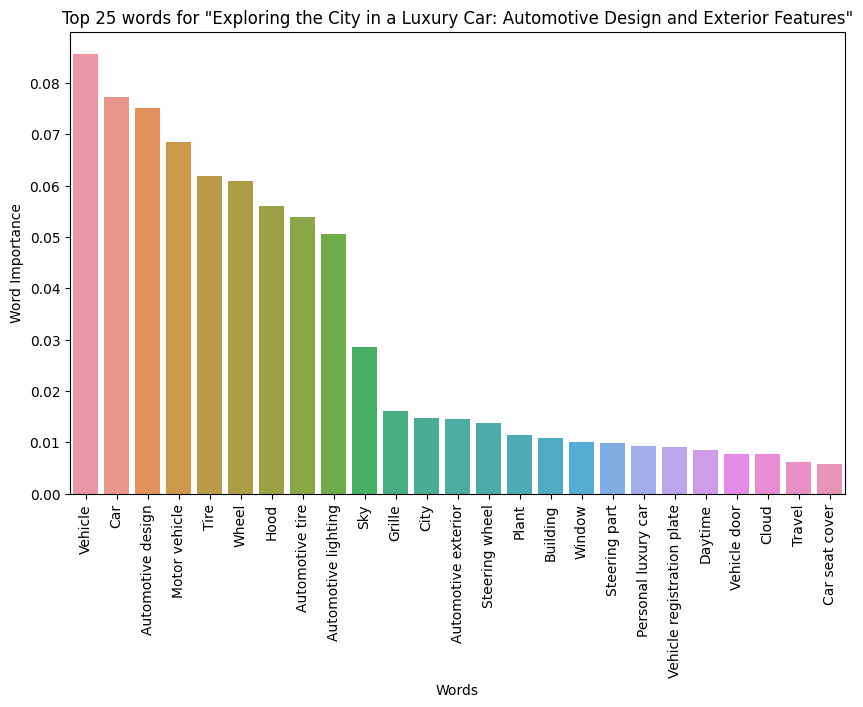

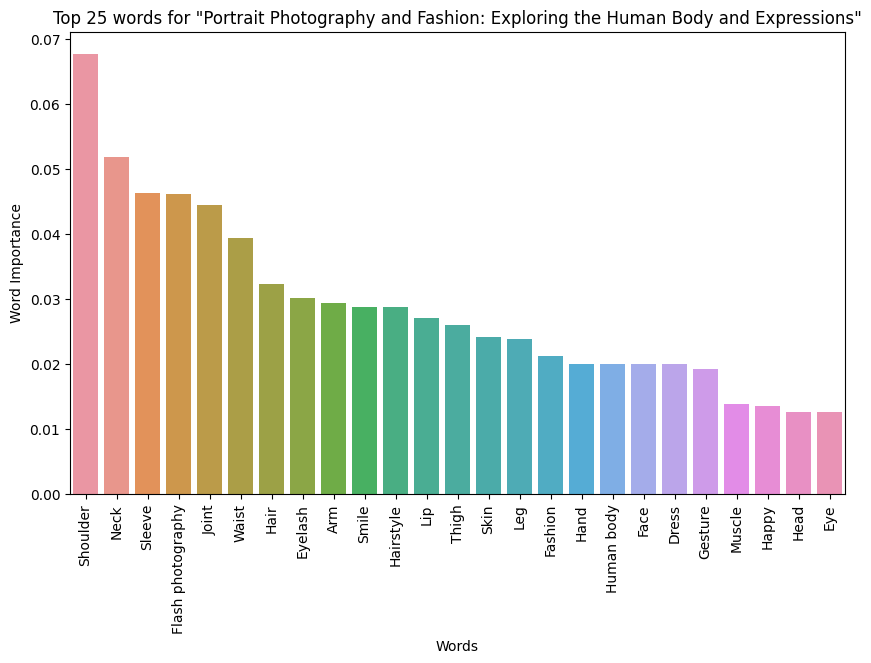

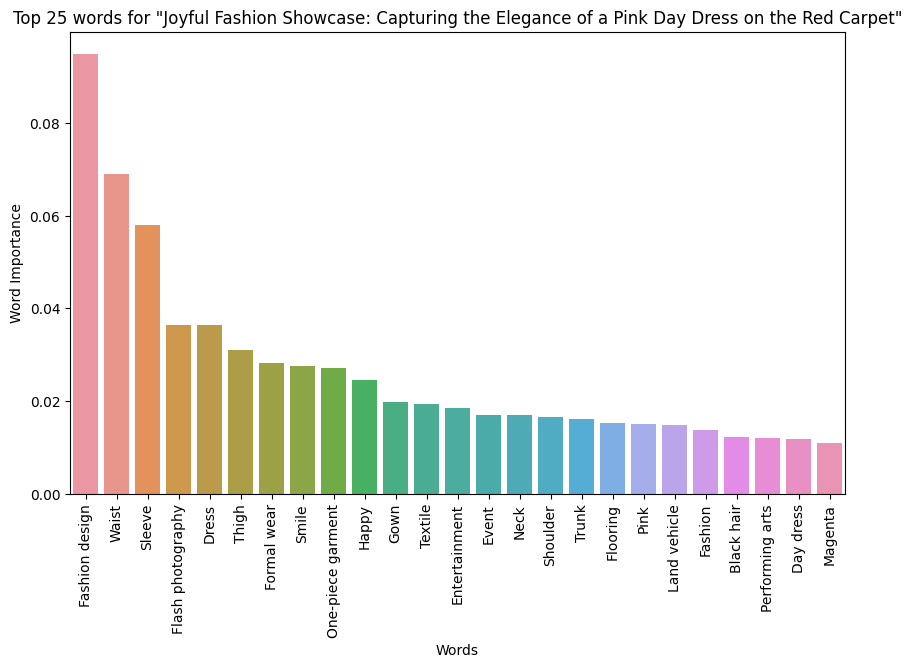

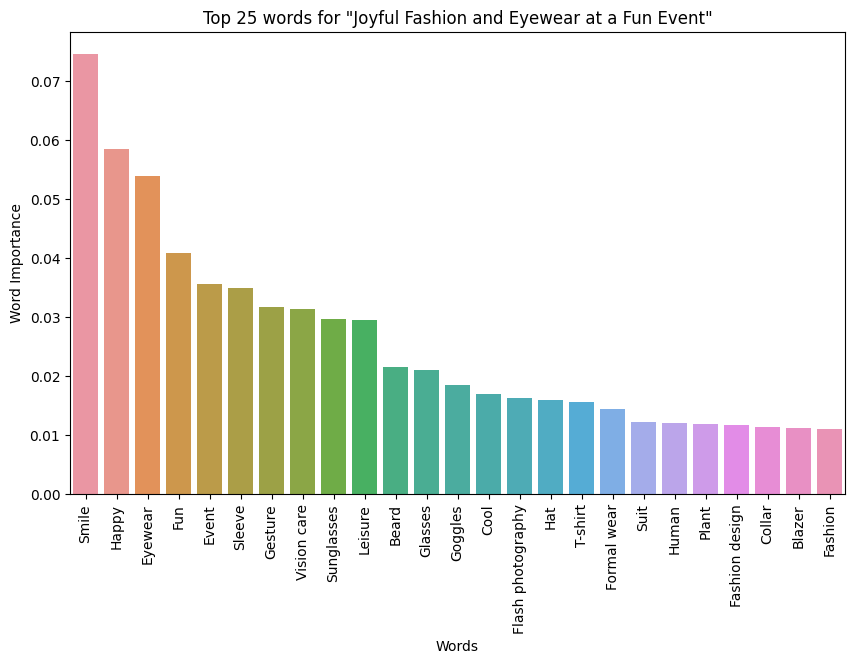

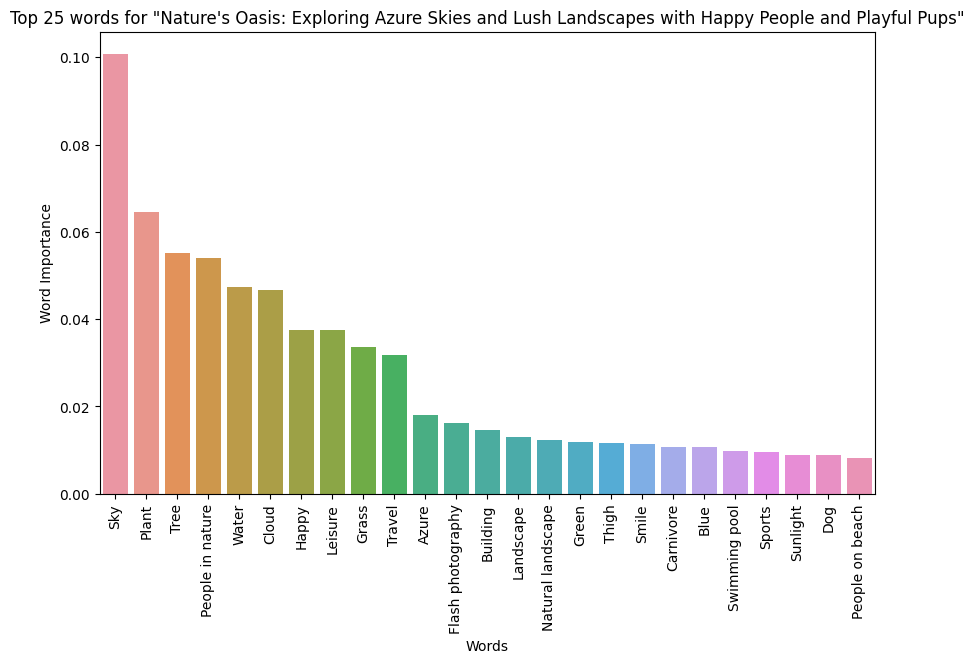

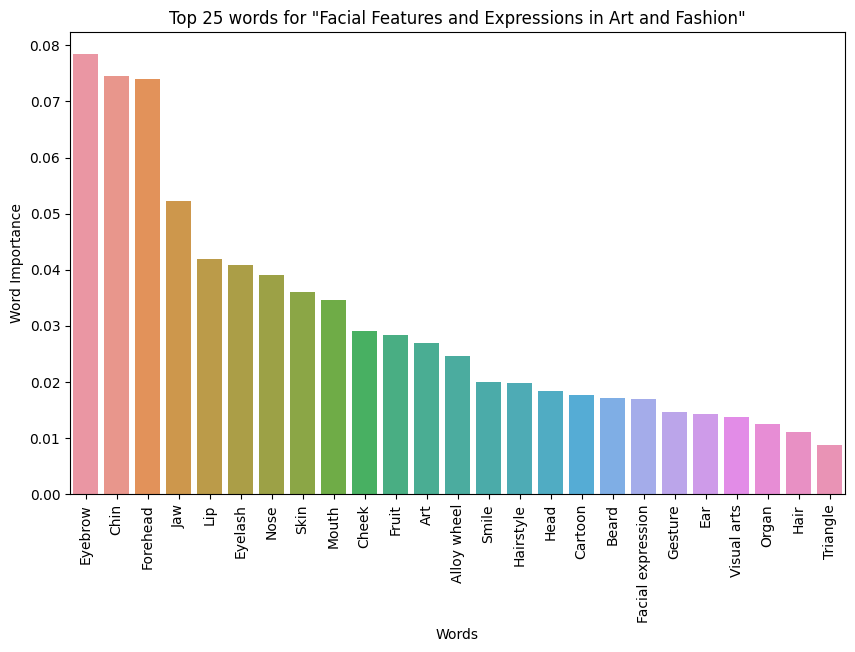

In [9]:
# Perform LDA with the optimal number of topics
topics = perform_lda(labels_list, optimal_num_topics)

# Extract the top 25 words for each topic and their weights
top_words_per_topic = []
for i, row_list in enumerate(topics[0].print_topics(num_topics=optimal_num_topics, num_words=25)):
    top_words = [word for word, prob in topics[0].show_topic(i, topn=25)]
    top_words_per_topic.append((f"Topic {i+1}", top_words))

# Initialize OpenAI API for GPT-3.5
openai.api_key = os.getenv("OPENAI_API_KEY")

# Function to generate topic names using OpenAI GPT-3.5
def generate_topic_names(top_words_per_topic):
    topic_names = []
    for _, words in top_words_per_topic:
        prompt = f"Generate a concise LDA topic name from Instagram post based on following image label keywords: {', '.join(words)}."
        response = openai.Completion.create(
            model="gpt-3.5-turbo-instruct",
            prompt=prompt,
            temperature=0.0,
            max_tokens=60,
            top_p=0.9,
            frequency_penalty=0.5,
            presence_penalty=0.5
        )
        topic_name = response.choices[0].text.strip()
        print(topic_name)
        topic_names.append(topic_name)
    return topic_names

# Generate topic names
topic_names = generate_topic_names(top_words_per_topic)

# Combine topic names with their top words
topics_with_names = []
for i, (topic, words) in enumerate(top_words_per_topic):
    topic_name = topic_names[i] if i < len(topic_names) else f"Topic {i+1}"
    topics_with_names.append((topic_name, ", ".join(words)))

# Convert to DataFrame
topics_df = pd.DataFrame(topics_with_names, columns=['Topic Name', 'Top Words'])

# Save the DataFrame to a CSV file
topics_df.to_csv('./data/topics_with_names.csv', index=False)

# Visualization of the top words for each topic
for i, (topic_name, words) in enumerate(topics_with_names):
    plt.figure(figsize=(10, 6))
    word_probs = topics[0].show_topic(i, topn=25)  # Adjusted to fetch top 25 words and their probabilities
    sns.barplot(x=[word for word, _ in word_probs], y=[prob for _, prob in word_probs])
    plt.xticks(rotation=90)
    plt.title(f'Top 25 words for {topic_name}')
    plt.ylabel('Word Importance')
    plt.xlabel('Words')
    plt.show()

## 3. Analyze engagement

In [57]:
# Iterate through each row in the DataFrame to assign each post to a topic based on its labels and add the topic name to combined_df
for index, row in combined_df.iterrows():
    # Convert the labels for the post into a BOW format
    bow = topics[1].doc2bow(row['Labels'])
    # Get the topic distribution for the post
    post_topics = topics[0].get_document_topics(bow)
    # Sort the topics by probability (highest probability first)
    post_topics = sorted(post_topics, key=lambda x: x[1], reverse=True)
    # Get the highest probability topic
    if post_topics:
        topic_num, _ = post_topics[0]
        # Assign the topic name to a new column in the DataFrame
        combined_df.at[index, 'Assigned Topic'] = topic_names[topic_num]
    else:
        # If no topic was assigned, label it as 'Undefined'
        combined_df.at[index, 'Assigned Topic'] = 'Undefined'

# Print the updated DataFrame
print(combined_df.head())

                                          Image_Path      Username  \
0  ./data/posts/aashnashroff_969148_3000403601659...  aashnashroff   
1  ./data/posts/aashnashroff_969148_3000403601659...  aashnashroff   
2  ./data/posts/aashnashroff_969148_3000403601659...  aashnashroff   
3  ./data/posts/aashnashroff_969148_3000403601659...  aashnashroff   
4  ./data/posts/aashnashroff_969148_3000403601659...  aashnashroff   

   Follower_Count              Post_ID  Post_Likes  Post_Comments  \
0          969148  3000403601659402518       25980             65   
1          969148  3000403601659402518       25980             65   
2          969148  3000403601659402518       25980             65   
3          969148  3000403601659402518       25980             65   
4          969148  3000403601659402518       25980             65   

                                              Labels  \
0  [Sky, Cloud, Leg, Flash photography, Happy, Tr...   
1  [Smile, Cloud, Sky, Daytime, Photograph, Trave...

In [66]:
# Calculate the frequency of each Assigned Topic
topic_frequency = combined_df['Assigned Topic'].value_counts(normalize=True)

# Map the frequency to each row in the DataFrame as the Assigned Topic Weight
combined_df['Assigned Topic Weight'] = combined_df['Assigned Topic'].map(topic_frequency)

print(combined_df.head())

                                             Image_Path          Username  \
1378  ./data/posts/halfbakedharvest_5247243_29964078...  halfbakedharvest   
1377  ./data/posts/halfbakedharvest_5247243_29906126...  halfbakedharvest   
1376  ./data/posts/halfbakedharvest_5247243_29862692...  halfbakedharvest   
1379  ./data/posts/halfbakedharvest_5247243_30007507...  halfbakedharvest   
1341  ./data/posts/halfbakedharvest_5247243_28695493...  halfbakedharvest   

      Follower_Count              Post_ID  Post_Likes  Post_Comments  \
1378         5247243  2996407846187385570      247631         693966   
1377         5247243  2990612658156456674      212513         515973   
1376         5247243  2986269265263400579      112425         331474   
1379         5247243  3000750743145862289      160070         239765   
1341         5247243  2869549391481578933       94986         184733   

                                                 Labels  \
1378  [Kitchen appliance, Christmas tree, Hom

In [73]:
# Sort the DataFrame by the number of comments to identify high and low engagement posts
combined_df = combined_df.sort_values(by='Post_Comments', ascending=False)

# Calculate quartiles to separate the DataFrame into high and low engagement groups
high_engagement_threshold = combined_df['Post_Comments'].quantile(0.75)
low_engagement_threshold = combined_df['Post_Comments'].quantile(0.25)

# Adjusting the condition to include posts at the threshold for high engagement and exclude them for low engagement
high_engagement_df = combined_df[combined_df['Post_Comments'] >= high_engagement_threshold]
low_engagement_df = combined_df[combined_df['Post_Comments'] <= low_engagement_threshold]

# Group the data by 'Assigned Topic' to calculate the average weight for each topic within high and low engagement groups
high_engagement_avg_weights = high_engagement_df.groupby('Assigned Topic')['Assigned Topic Weight'].sum().reset_index(name='Average Weight High Engagement')
low_engagement_avg_weights = low_engagement_df.groupby('Assigned Topic')['Assigned Topic Weight'].sum().reset_index(name='Average Weight Low Engagement')

# Min-max normalize the average weights for comparison
high_engagement_avg_weights['Average Weight High Engagement'] = (high_engagement_avg_weights['Average Weight High Engagement'] - high_engagement_avg_weights['Average Weight High Engagement'].min()) / (high_engagement_avg_weights['Average Weight High Engagement'].max() - high_engagement_avg_weights['Average Weight High Engagement'].min())
low_engagement_avg_weights['Average Weight Low Engagement'] = (low_engagement_avg_weights['Average Weight Low Engagement'] - low_engagement_avg_weights['Average Weight Low Engagement'].min()) / (low_engagement_avg_weights['Average Weight Low Engagement'].max() - low_engagement_avg_weights['Average Weight Low Engagement'].min())

# Merge the high and low engagement average weights for comparison
engagement_comparison_df = pd.merge(high_engagement_avg_weights, low_engagement_avg_weights, on='Assigned Topic', how='outer')

# Fill NaN values with 0 for topics that do not appear in either high or low engagement groups
engagement_comparison_df.fillna(0, inplace=True)

# Display the comparison
print(engagement_comparison_df)

                                       Assigned Topic  \
0   "Cozy Home Decor: Wood, Furniture, and Natural...   
1   "Exploring Culinary Creations: A Journey Throu...   
2   "Exploring the City in a Luxury Car: Automotiv...   
3   "Facial Features and Expressions in Art and Fa...   
4   "Graphic Design for Brand Promotion on Social ...   
5   "Joyful Fashion Showcase: Capturing the Elegan...   
6         "Joyful Fashion and Eyewear at a Fun Event"   
7   "Musical Performance in Sportswear: Exploring ...   
8   "Nature's Oasis: Exploring Azure Skies and Lus...   
9   "Portrait Photography and Fashion: Exploring t...   
10  "Sports Uniforms and Gear in Action: A Snapsho...   

    Average Weight High Engagement  Average Weight Low Engagement  
0                         0.043360                       0.127175  
1                         0.090549                       0.491115  
2                         0.067106                       0.042458  
3                         0.002205         

### Conclusion on Topics with Higher and Lower Engagement

The analysis of engagement across updated topic names provides deeper insights into audience preferences and content performance dynamics. Topics such as "Joyful Fashion and Eyewear at a Fun Event" and "Portrait Photography and Fashion: Exploring the Human Body and Expressions" emerge as top performers in terms of engagement weights, highlighting a pronounced audience interest in fashion and photography. These topics likely resonate due to their visual appeal and the relevance they hold in current trends.

Conversely, topics like "Facial Features and Expressions in Art and Fashion" and "Musical Performance in Sportswear: Exploring the Human Leg and Flash Photography" show lower engagement weights. This suggests that these subjects may not align as closely with the audience's interests or might be less prevalent in discussions, potentially due to niche appeal or less frequent content production in these areas.

Notably, some topics display a significant disparity between high and low engagement weights, such as "Exploring Culinary Creations: A Journey Through Dishes, Ingredients, and Tableware" and "Graphic Design for Brand Promotion on Social Media." This indicates that while these topics can generate high interest, their ability to consistently engage the audience across all content varies. This inconsistency presents an opportunity for content creators to investigate what specific aspects within these topics captivate audience attention and to adapt their content strategy accordingly.

In summary, the updated data suggests that topics related to fashion, photography, and visually engaging content continue to attract higher engagement, underscoring a visual and aesthetic preference in the audience's consumption habits. Content creators are advised to focus on these areas or integrate visual elements into their content strategies to boost engagement.

# Client Recommendations

Based on our analysis, to enhance engagement on your Instagram page, we recommend focusing on creating and sharing content that aligns with high-engagement topics identified in our study. Specifically, content related to fashion, photography, and visually appealing subjects has shown to attract more interaction. Incorporating elements such as joyful fashion, eyewear, and portrait photography can significantly boost your engagement rates. Additionally, exploring and integrating trending topics within these categories can further captivate your audience's interest.

It's also crucial to analyze the disparity in engagement across different topics. For topics that show potential but have inconsistent engagement, delve deeper to understand what aspects resonate most with your audience. This could involve experimenting with different content formats, storytelling techniques, or visual presentations.

Lastly, while focusing on high-engagement topics, don't overlook the value of niche subjects that could attract a dedicated follower base. Tailoring content to cater to specific interests, even if they fall within lower engagement categories, can help in building a loyal community around your brand.

Implementing these strategies, backed by data-driven insights from our analysis, can lead to a noticeable increase in engagement on your Instagram page.